## 拉勾网数据分析岗位招聘信息分析
数据来源于拉勾网，信息爬取日期为2018-6-11, 爬虫已上传到GitHub，地址：https://github.com/MabelFan/crawl_web.git   

数据变量有10项,介绍如下：
1. companyFullName: 公司全称   
2. positionName： 岗位全称     
3. positionLables：岗位关键词      
4. salary：参考月薪， 上下限模式               
5. workYear：要求工作经验                
6. createTime：岗位开始招聘日期             
7. companySize：公司规模           
8. companyLabelList：公司福利        
9. city：岗位所在的城市           
10. district：岗位所在的城区           

### 导入库 

In [1]:
import os,re,jieba
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import folium
from folium.plugins import HeatMap
import scipy
from scipy.misc import imread
from scipy.stats import norm
from PIL import Image
from wordcloud import WordCloud,ImageColorGenerator
from collections import Counter,defaultdict

% matplotlib inline

### 一、读取数据

In [2]:
jobs_lagou = pd.read_excel('jobs_lagou.xlsx')
jobs_lagou.sample(5)

,companyFullName,positionName,positionLables,salary,workYear,createTime,companySize,companyLabelList,city,district
636,徐州稻壳信息科技有限公司,数据分析师,"['旅游', '广告营销', '广告投放', 'SEM']",5k-10k,1-3年,2018-06-04 10:13:44,50-150人,"['""""']",徐州,云龙区
1769,四川优家库信息技术有限公司,数据分析,"['大数据', '数据挖掘', 'SPSS']",10k-20k,5-10年,2018-05-25 17:16:02,50-150人,"['股票期权', '绩效奖金', '带薪年假']",成都,锦江区
390,快看世界（北京）科技有限公司,数据分析,"['金融', '数据挖掘', '用户研究']",15k-30k,1-3年,2018-06-06 10:58:05,150-500人,"['节日礼物', '带薪年假', '每日水果零食', '股票期权']",北京,朝阳区
1399,蓝港在线（北京）科技有限公司,数据分析总监,"['移动互联网', '游戏', '运营', '大数据']",25k-35k,5-10年,2018-05-14 10:25:34,500-2000人,"['年底双薪', '节日礼物', '技能培训', '绩效奖金']",北京,朝阳区
2628,百度在线网络技术（北京）有限公司,品牌广告产品部_资深数据分析师/业务分析师,"['电商', '广告营销', '产品经理']",30k-50k,5-10年,2018-06-11 10:47:38,2000人以上,"['股票期权', '弹性工作', '五险一金', '免费班车']",北京,海淀区


In [3]:
len(jobs_lagou)

3043

### 二、数据清洗
首先，全面了解所获取的数据情况，然后从重复值、空值、异常值、数据类型等对数据进行清洗、整理。

In [4]:
jobs_lagou_clean = jobs_lagou.copy()
jobs_lagou_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3043 entries, 0 to 3042
Data columns (total 10 columns):
companyFullName     3043 non-null object
positionName        3043 non-null object
positionLables      3043 non-null object
salary              3043 non-null object
workYear            3043 non-null object
createTime          3043 non-null object
companySize         3043 non-null object
companyLabelList    3043 non-null object
city                3043 non-null object
district            3043 non-null object
dtypes: object(10)
memory usage: 237.8+ KB


#### 1. 查找重复项
以指定列的值均相同计为重复行，对重复行进行直接删除。   
删除重复行的直接操作：data.drop_duplicates([cols])

In [5]:
sum(jobs_lagou_clean.duplicated(['companyFullName','positionName','positionLables',\
                                 'salary','workYear','city','district']))

47

In [6]:
jobs_lagou_clean.drop_duplicates(['companyFullName','positionName','positionLables',\
                                 'salary','workYear','city','district'],inplace=True)
sum(jobs_lagou_clean.duplicated(['companyFullName','positionName','positionLables',\
                                 'salary','workYear','city','district']))

0

In [7]:
len(jobs_lagou_clean)

2996

对于指定列，重复行47项,删除后所得非重复行的数据2996项。

#### 2. 空值

In [8]:
jobs_lagou_clean.isnull().sum()

companyFullName     0
positionName        0
positionLables      0
salary              0
workYear            0
createTime          0
companySize         0
companyLabelList    0
city                0
district            0
dtype: int64

除positionLables和companyLabelList为list外，其他列中的值均为str，不存在空值；而对于所提到的两列，是否不为空对主要分析的内容并不影响。

#### 3. 数据类型
1) 将createTime列的数值类型由object改为datetime。

In [9]:
#pd.options.mode.chained_assignment = None   # disable SettingWithCopyWarning
jobs_lagou_clean.loc[:,'createTime']=pd.to_datetime(jobs_lagou_clean['createTime'])

2) 将salary列转成数据类型，因上、下限不定，且区间重合度高，故分别获取薪资下限、下限，并添加平均值列。

In [10]:
salaryRegex1 = re.compile(r'(\d+k)\s*-\s*(\d+k)',re.I)
salaryRegex2 = re.compile(r'k', re.I)

jobs_lagou_clean['salary_L']=pd.Series()
jobs_lagou_clean['salary_U']=pd.Series()
jobs_lagou_clean['salary_A']=pd.Series()


for i in jobs_lagou_clean['salary'].index:
    jobs_lagou_clean.loc[i,'salary_L'] =  salaryRegex2.sub('000', salaryRegex1.search(jobs_lagou_clean.loc[i,'salary']).group(1))
    jobs_lagou_clean.loc[i,'salary_U'] =  salaryRegex2.sub('000', salaryRegex1.search(jobs_lagou_clean.loc[i,'salary']).group(2))
jobs_lagou_clean['salary_L'] = jobs_lagou_clean['salary_L'].astype('int64')
jobs_lagou_clean['salary_U'] = jobs_lagou_clean['salary_U'].astype('int64')
jobs_lagou_clean['salary_A']= (jobs_lagou_clean['salary_L'] + jobs_lagou_clean['salary_U'])/2
jobs_lagou_clean['salary_A'] = jobs_lagou_clean['salary_A'].astype('int64')

3) 对数据类型为categorical的列，workYear和companySize,各添加一列-数据分类变量，便于后续分析。

In [11]:
jobs_lagou_clean['workYear'].unique()

array(['3-5年', '5-10年', '1-3年', '不限', '1年以下', '10年以上', '应届毕业生'],
      dtype=object)

In [12]:
workYear_dict = {'应届毕业生':1,'1年以下':2,'不限':3,'1-3年':4,'3-5年':5,'5-10年':6,'10年以上':7}
jobs_lagou_clean['ClsworkY'] = jobs_lagou_clean['workYear'].map(workYear_dict)

In [13]:
jobs_lagou_clean['companySize'].unique()

array(['2000人以上', '150-500人', '50-150人', '15-50人', '500-2000人', '少于15人'],
      dtype=object)

In [14]:
size_dict={'少于15人':1,'15-50人':2,'50-150人':3,'150-500人':4, '500-2000人':5, '2000人以上':6}
jobs_lagou_clean['ClscompSize'] = jobs_lagou_clean['companySize'].map(size_dict)

#### 4. 确认是否存在异常值
主要针对薪资列

In [15]:
jobs_lagou_clean.describe()

,salary_L,salary_U,salary_A,ClsworkY,ClscompSize
count,2996.000000,2996.000000,2996.000000,2996.000000,2996.000000
mean,12589.786382,22108.144192,17348.965287,4.413551,4.650534
std,6283.052103,11321.039277,8700.256301,0.884406,1.314248
min,1000.000000,2000.000000,1500.000000,1.000000,1.000000
25%,8000.000000,15000.000000,11500.000000,4.000000,4.000000
50%,10000.000000,20000.000000,15000.000000,4.000000,5.000000
75%,15000.000000,30000.000000,22500.000000,5.000000,6.000000
max,60000.000000,100000.000000,80000.000000,7.000000,6.000000


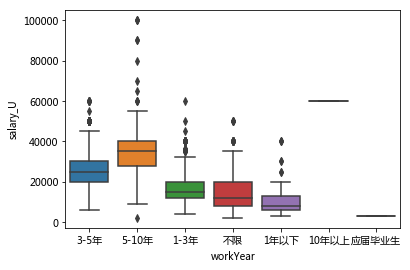

In [16]:
plt.rcParams['font.sans-serif']=['Microsoft YaHei']
sns.boxplot(x='workYear',y='salary_U',data = jobs_lagou_clean);

可以看出，最高薪跟75%位置的薪资也是差距很大的，同时选择workYear用箱图来展示数据，可以看到很多“outliers"。   
但在薪资待遇这方面，总是有人可以拿到很高的水平，不作为异常值处理。

In [17]:
jobs_lagou_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2996 entries, 0 to 3042
Data columns (total 15 columns):
companyFullName     2996 non-null object
positionName        2996 non-null object
positionLables      2996 non-null object
salary              2996 non-null object
workYear            2996 non-null object
createTime          2996 non-null datetime64[ns]
companySize         2996 non-null object
companyLabelList    2996 non-null object
city                2996 non-null object
district            2996 non-null object
salary_L            2996 non-null int64
salary_U            2996 non-null int64
salary_A            2996 non-null int64
ClsworkY            2996 non-null int64
ClscompSize         2996 non-null int64
dtypes: datetime64[ns](1), int64(5), object(9)
memory usage: 454.5+ KB


至此，数据清洗、整理完成。   
<br>


### 三、数据分析    
#### *提出问题    
1. 各个地区对数据分析岗位的需求情况如何？ 
2. 岗位名称和岗位关键词分析；提取主要技能要求；  
3. 薪资水平与哪些因素有关？如何提高薪资待遇？      
4. 公司侧重的福利主要有哪些？  
5. 厦门对该岗位的需求情况及经验要求和薪资水平情况。  
6. 重点了解一下部分企业的需求与薪酬情况。   

#### 问题1: 各个地区对数据分析岗位的需求情况如何？   
对各个地区的招聘职位发布数量进行统计分析，针对需求量少于10的城市全部归为“其他”项。

In [18]:
count_by_city = jobs_lagou_clean.groupby('city')['positionName'].count().sort_values(ascending=False)
#count_by_city

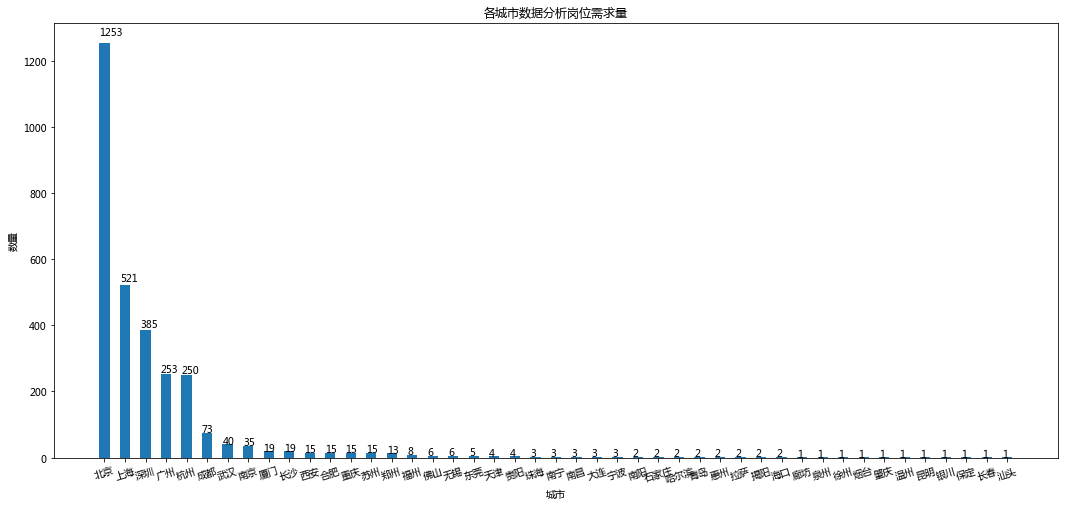

In [19]:
plt.rcParams['font.sans-serif']=['Microsoft YaHei'] 

fig, ax = plt.subplots(1,1,figsize=(18,8))
rect = ax.bar(np.arange(len(count_by_city)),count_by_city.values,width = 0.5)

# 设置x轴刻度标签
def auto_xticks(rects, xticks):
    x = []
    for rect in rects:
        x.append(rect.get_x() + rect.get_width()/2)
    x = tuple(x)
    plt.xticks(x,xticks)
auto_xticks(rect,count_by_city.index)
ax.set_xticklabels(count_by_city.index,rotation=17)

# 设置数据标签
def auto_tag(rects,data=None,offset = [0,0]):
    for rect in rects:
        try:
            height = rect.get_height()
            plt.text(rect.get_x(), 1.02*height, '%s' % int(height))
        except AttributeError:
            x = range(len(data))
            y = data.values
            for i in range(len(x)):
                plt.text(x[1]+offset[0],y[i]+0.08+offset[1],y[i])
auto_tag(rect,offset=[-1,0])

ax.set(title='各城市数据分析岗位需求量', xlabel='城市',ylabel='数量')

plt.show()

In [20]:
#合并数据并删除需求较少未细分的城市，将数量转成int
jobs_lagou_clean_city = jobs_lagou_clean['city'].value_counts()
print('城市数量：',len(jobs_lagou_clean_city.index),'岗位需求总数量：',jobs_lagou_clean_city.values.sum())
# 将招聘需求量>10的城市定义为主要城市
job_counts_main_cities  = jobs_lagou_clean_city[jobs_lagou_clean_city.values>10]

# 其他需求全部合并为其他
other_cities = pd.Series(data=jobs_lagou_clean_city.sum() - job_counts_main_cities.sum(),index=['其他'])

job_counts_main_cities = job_counts_main_cities.add(other_cities,fill_value=0)
job_counts_main_cities.astype('int')

城市数量： 45 岗位需求总数量： 2996


上海     521
其他      75
北京    1253
南京      35
厦门      19
合肥      15
广州     253
成都      73
杭州     250
武汉      40
深圳     385
苏州      15
西安      15
郑州      13
重庆      15
长沙      19
dtype: int64

In [21]:
#将整理好的Series转成DataFrame
df_jobs_counts_main_cities = pd.DataFrame({'city':job_counts_main_cities.index,\
                                    'Job_counts':job_counts_main_cities.values})
df_jobs_counts_main_cities.sort_values(['Job_counts'], ascending=False,inplace=True)
df_jobs_counts_main_cities.reset_index(inplace=True,drop=True)
#df_jobs_main_cities

<b>Point of reference</b>    
If your x variable is categorical then it can not draw a horizontal barplot.    
If your y variable is categorical then it can not draw a vertical barplot.    
One way could be to change orient to v

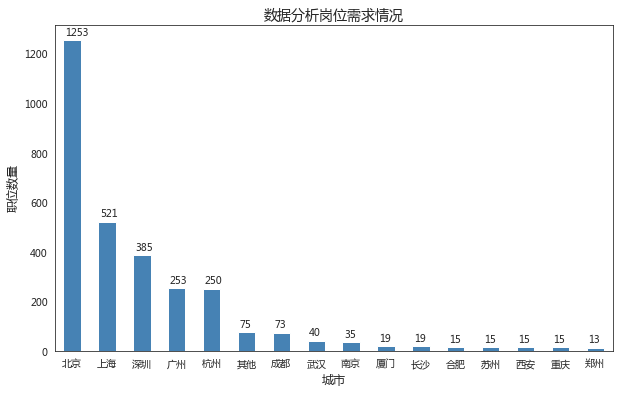

In [22]:
sns.set_style("white", {'font.sans-serif':'Microsoft YaHei'})

plt.figure(figsize=(10, 6))

df_jobs_counts_main_cities['Job_counts'].plot.bar(x='city',width=0.5,color='steelblue')
plt.title('数据分析岗位需求情况',fontsize=14)
plt.xlabel('城市',fontsize=12)
plt.ylabel('职位数量',fontsize=12)
plt.xticks(np.arange(len(df_jobs_counts_main_cities['city'])),list(df_jobs_counts_main_cities['city']),rotation=0)

ht = np.arange(len(df_jobs_counts_main_cities['Job_counts']))
vt = list(df_jobs_counts_main_cities['Job_counts'])
for x,y in zip(ht,vt): 
    plt.text(x-0.2,y+20,'%s' % int(y),fontsize=10)

plt.show();
  
#fig.savefig('./jobs_by_city.png')

拉勾网上，总计有45个城市对数据分析岗位有招聘需求，岗位总需求量为2996个，但只有其中的15个城市需求数量在三位数以上，且以北京的需求量为全国第一，占总需求量的近一半。排在前5的分别是：北京，上海，深圳，广州，杭州。    
<br>
数据分析这一岗位大量集中在北上广深四大一线城市，以及杭州这个互联网和电子商务企业的聚集地。紧随其后的是几大城市是热门的新一线城市，如成都、武汉、南京，厦门近年来也在注重互联网、信息产业的发展，需求量也挤进前十了。    

虽然拉勾网主要是以互联网招聘为主，于整个招聘需求来说可能存在一点偏颇，但整体情况上应该差异不大。

#### 问题2. 岗位名称和岗位关键词分析    
对岗位关键词进行整理写入txt文件，首先创建词云，对整体上的词频有一个了解。  
然后对关键词进行分析，是否有相应的属性可单独再作分析。

In [23]:
def get_words(col):
    # get the words and write it to a file
    filepath = os.path.join(os.getcwd()+'/'+col+'.txt')
    file = open(filepath, 'w')
    for i in jobs_lagou_clean[col].index:
        keys = jobs_lagou_clean.loc[i,col][1:-1]
        if len(keys) > 0:
            file.write(keys + ", ")
    file.close()

    # Read the whole text.
    text = open(filepath,'r').read()
    return text


In [24]:
def draw_wordcloud(text):
    # read the mask image
    xiamen_mask = np.array(Image.open('/Users/mabelfan/Downloads/longmao.jpeg'))

    # Generate a word cloud image
    font = r'/Library/Fonts/msyh.ttf'
    wordcloud = WordCloud(collocations=False, background_color='white',\
                          font_path=font, width=1800, height=1200,mask=xiamen_mask).generate(text)

    plt.figure(figsize=(8,8))

    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title('岗位关键词的词云')
    plt.axis("off")
    plt.show()

    # wc.to_file('岗位关键词.png')  # 把词云保存下来 

In [25]:
job_keywrods = get_words('positionLables')

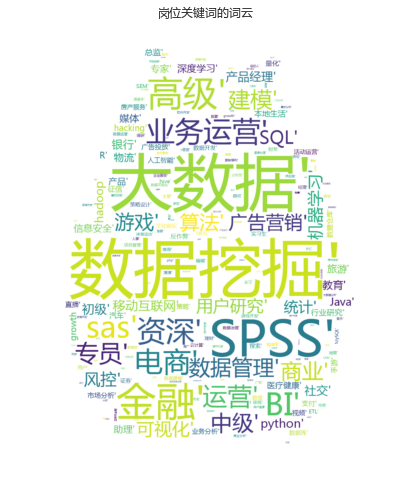

In [26]:
draw_wordcloud(job_keywrods)

从词云中可看到，频率最高的是数据挖掘，看来很多岗位都有提及；   
然后是大数据，这可能是为了区别传统的数据分析。      
对于频率较高的关键词，主要包括几大类：技能、岗位级别、岗位方向、行业等。   

因岗位名称中也多有提及到岗位的工作方向、技能、水平要求等，故尝试同时对岗位名称进行关键词提取。 

In [27]:
positionWords = []
for i in jobs_lagou_clean['positionName'].index:
    positionWords.append(jobs_lagou_clean.loc[i,'positionName'])

positionWords_t = ",".join(positionWords)
wordlist_jieba = jieba.cut(positionWords_t, cut_all=False)
stopwords = {}.fromkeys([line.rstrip() for line in open('/Users/mabelfan/Documents/supports/stopwords.txt','r')])
final_wds = ''
for word in wordlist_jieba:
    if word not in stopwords:
        final_wds += word
        final_wds += " "

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/yz/qcyb2b3n46j6_vlgcyy_n67w0000gn/T/jieba.cache
Loading model cost 1.025 seconds.
Prefix dict has been built succesfully.


In [28]:
# 找出频率高的关键词
def most_common_words(text,n):
    patt = re.compile("\w+")
    counter = Counter(patt.findall(text))
    for word, times in counter.most_common(n):
        print(word, times)

In [29]:
most_common_words(final_wds,20)

数据 1860
分析师 1786
数据分析 1237
高级 370
工程师 256
专员 186
方向 159
经理 158
运营 120
资深 92
专家 77
BI 66
商业 65
产品 62
主管 55
岗 53
风控 52
员 51
业务 44
游戏 42


从前20的关键词来看，除了岗位搜索的关键发词‘数据分析’外，其他词的词频最高的是‘高级’，词频也仅有370,之后的其他词频率不仅更低，价值也不高，故对岗位名称中的关键词分析到此为止。 

In [30]:
text = get_words('positionLables')
most_common_words(text,20)

数据挖掘 1345
大数据 1260
SPSS 723
金融 444
高级 345
BI 257
sas 247
业务运营 230
资深 229
电商 223
运营 170
专员 156
建模 135
中级 131
商业 127
数据管理 126
游戏 107
算法 106
广告营销 96
SQL 89


从岗位关键词中提取到的<b>关键词</b>主要集中在这几类：   
1.<b>技能</b>： 数据挖掘，SPSS，BI，SAS，建模，算法    
2.<b>行业</b>：金融，电商，游戏    
3.<b>岗位级别</b>：专员，中级，高级，资深   
4.<b>职责方向</b>：（业务）运营，商业，数据管理    
注：仅考虑词频达到100的关键词。

In [30]:
jobs_keyWord = jobs_lagou_clean[['positionName','positionLables','salary_A']]

In [31]:
jobs_keyWord['salary_A'].describe()

count     2996.000000
mean     17348.965287
std       8700.256301
min       1500.000000
25%      11500.000000
50%      15000.000000
75%      22500.000000
max      80000.000000
Name: salary_A, dtype: float64

In [32]:
pd.options.mode.chained_assignment = None 

In [33]:
#添加列来说明岗位关键词中的项，哪些对薪资有影响
def keyword_analysis(keyword):
    jobs_keyWord.loc[:,keyword] = jobs_keyWord.loc[:,'positionLables'].apply(lambda x:1 \
                                                                             if x[1:-1].find(keyword) != -1 else 0) 
    num = len(jobs_keyWord.loc[jobs_keyWord[keyword] == 1,:])
    print('提及'+keyword+'的岗位占比:','%.1f' % (num/len(jobs_keyWord)*100)+'%')

<b>技能</b> 

In [34]:
keyword_analysis('数据挖掘')
keyword_analysis('SPSS')
keyword_analysis('BI')
keyword_analysis('sas')
keyword_analysis('建模')
keyword_analysis('算法')

提及数据挖掘的岗位占比: 44.9%
提及SPSS的岗位占比: 24.1%
提及BI的岗位占比: 8.6%
提及sas的岗位占比: 8.2%
提及建模的岗位占比: 4.9%
提及算法的岗位占比: 3.6%


In [36]:
def get_data(keyword):
    dm = jobs_keyWord.loc[jobs_keyWord[keyword]==1,'salary_A']
    jobs_dm = pd.DataFrame(dm,columns=['salary_A'])
    jobs_dm['keys'] = keyword
    return jobs_dm

def concat_skill_data():
    data1 = get_data('数据挖掘')
    data2 = get_data('SPSS')
    data3 = get_data('BI')
    data4 = get_data('sas')
    data5 = get_data('建模')
    data6 = get_data('算法')
    data_all = pd.concat([data1,data2,data3,data4,data5,data6])
    return data_all

In [25]:
def salary_pat(x,pos):
    return '{:1.0f}k'.format(x*1e-3)
formatter = ticker.FuncFormatter(salary_pat)

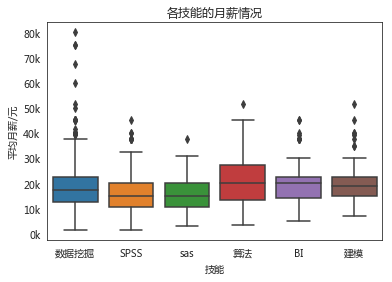

In [38]:
jobs_skill = concat_skill_data()

fig,ax = plt.subplots(1,1)
ax = sns.boxplot(x='keys',y='salary_A',data=jobs_skill.sort_values('salary_A'))
ax.set(title='各技能的月薪情况',xlabel='技能',ylabel='平均月薪/元')
ax.yaxis.set_major_formatter(formatter)
plt.show()

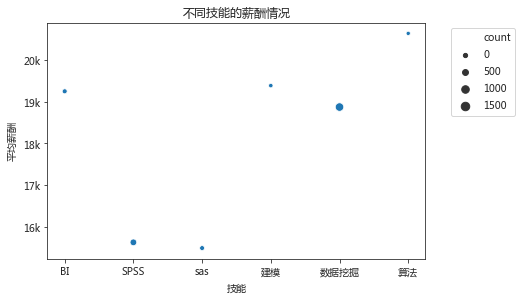

In [39]:
jobs_skill_group = jobs_skill.groupby('keys').mean()
jobs_skill_group['count'] = jobs_skill.groupby('keys').count()

sns.set_style("ticks",{'font.sans-serif':'Microsoft YaHei'})
ax = sns.scatterplot(x=jobs_skill_group.index,y='salary_A',size='count', data=jobs_skill_group)
plt.title('不同技能的薪酬情况')
plt.xlabel('技能')
plt.ylabel('平均薪酬')
ax.yaxis.set_major_formatter(formatter)
plt.legend(loc='upper right',ncol=1, bbox_to_anchor=(1.25, 1.0))
plt.subplots_adjust(top=0.9, bottom=0.08,right=1.0);
#ax.savefig('Test.png', bbox_inches='tight')

In [40]:
skill_dict = {'SPSS':1,'sas':2,'数据挖掘':3,'BI':4,'建模':5,'算法':6}
jobs_skill['class'] = jobs_skill['keys'].map(skill_dict)
jobs_skill['salary_A'].corr(jobs_skill['class'])

0.18236997151293277

将提及各项技能的数据提取出来后合并进行横向对比分析    
提及建模的岗位薪资起点是所有项中最高的，薪资水平也比较集中，在20k左右，有不少机会获得更高薪,平均月薪位于算法之后，提及率比较低；  
提及算法的平均薪资最高，但薪资分布范围是最广的，说明招聘单位提供的月薪差异较大，但提及率高于建模；  
提及数据挖掘的岗位最多，平均薪资稍低于前两者，薪资分布围比建模的要宽一些，但获得更高薪的机会最多；   
稍感意外的是，提及BI的岗位平均月薪超过数据挖掘，在19k之上；   
SPSS与SAS的情况较为接近，平均薪资均比前三项要低，但SPSS的提及率仅次于数据挖掘，需求较多。

关于技能情况与月薪的相关性分析，得出相关性系数为0.18, 处于较低的水平。

In [41]:
jobs_keyWord['skill'] = jobs_keyWord[['数据挖掘','SPSS','sas','BI','建模','算法']].sum(axis=1)

<Figure size 576x576 with 0 Axes>

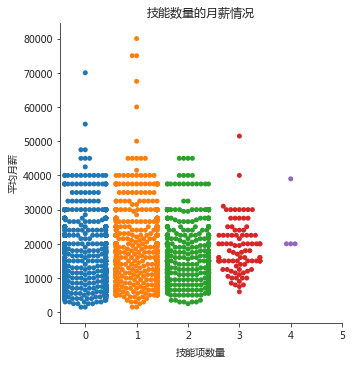

In [42]:
fig = plt.figure(figsize=(8,8))
sns.set_style("ticks",{'font.sans-serif':'Microsoft YaHei'})
ax = sns.catplot(x='skill',y='salary_A',kind='swarm',data=jobs_keyWord)
plt.xticks(np.arange(6),[0,1,2,3,4,5])
plt.title('技能数量的月薪情况')
plt.xlabel('技能项数量')
plt.ylabel('平均月薪')

plt.show();

将有提及的6项技能按项数统计，有不少岗位均未提及，月薪分布与提及1项的情况较为接近，只是获得极高薪的情况更少；       
提及到1项的岗位月薪分布在30k以上的相对更多，获得极高薪的情况也是最多的，结合之前提及数据挖掘的分布情况，应该较多是提及的数据挖掘；  
提及超过2项技能的岗位月薪下限会比前两种情况稍高一些，月薪在30k-40k之前有明显的断层；   
提及到3项的岗位，月薪下限相比提高较多，且月薪分布整体上有所上浮，月薪主要集中在10k-30k，高薪水部分不如只提及一项技能的情况；      
提及4项技能的有极少数，而没有岗位有提及到5项技能及以上的。

<b>技能分析小结</b> 
1. 提及率最高的技能是数据挖掘，占所有岗位的45%，平均月薪逼近19k，且拿极高月薪的机会最多；
2. 提及率排第二的技能是SPSS，占所有岗位的24%，但是平均月薪是这些技能中倒数第二，不到16k；
3. 其他技能的提及率均少于10%， 但以算法的平均月薪最高，其次是建模，BI紧随其后， 其中提及算法的岗位月薪差异相对更大；  
4. 大多数岗位会提及1-2项技能， 而提及1项技能的岗位获得极高薪的机会最多提及到4项及以上的情况非常少。

因此数据仅提取搜索页面的内容，未对岗位具体的职责和要求进行内容提取，而岗位的具体描述会更加准确地提出对技能的要求，所以，此部分的分析可能存在较大的偏颇，仅作初步参考。
 


<b>行业</b>

In [43]:
keyword_analysis('金融')
keyword_analysis('电商')
keyword_analysis('游戏')

提及金融的岗位占比: 15.0%
提及电商的岗位占比: 7.5%
提及游戏的岗位占比: 3.9%


In [44]:
def concat_idst_data():
    data1 = get_data('金融')
    data2 = get_data('电商')
    data3 = get_data('游戏')
    data_all = pd.concat([data1,data2,data3])
    return data_all
jobs_idst = concat_idst_data()

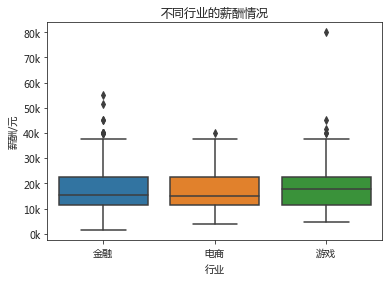

In [45]:
fig, ax = plt.subplots(1,1)
ax = sns.boxplot(x='keys',y='salary_A',data=jobs_idst)
ax.set(title='不同行业的薪酬情况',xlabel='行业',ylabel='薪酬/元')
ax.yaxis.set_major_formatter(formatter)

<b>行业情况分析小结</b>   
对行业类别提及的不多，前3项为金融，电商，游戏，这基本上就是对数据分析岗位需求较多的行业了。   
从薪资分布来看，金融与电商的薪酬情况较为接近，金融拿极高薪的情况稍多于电商，但电高的起薪要比金融高一些。   
游戏行业中，起薪会比其他两个高一些，平均薪资也会更高，拿高薪的情况会更少，但其中的最高薪却是来自游戏行业。

<b>岗位级别</b>

In [46]:
keyword_analysis('资深')
keyword_analysis('高级')
keyword_analysis('中级')
keyword_analysis('专员')

提及资深的岗位占比: 7.6%
提及高级的岗位占比: 11.5%
提及中级的岗位占比: 4.4%
提及专员的岗位占比: 5.2%


In [47]:
def concat_level_data():
    data1 = get_data('资深')
    data2 = get_data('高级')
    data3 = get_data('中级')
    data4 = get_data('专员')
    data_all = pd.concat([data1,data2,data3,data4])
    return data_all

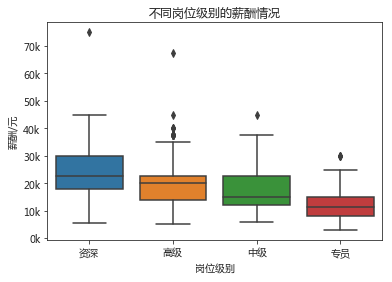

In [48]:
jobs_level = concat_level_data()
ax = sns.boxplot(x='keys',y='salary_A',data=jobs_level)
ax.set(title='不同岗位级别的薪酬情况',xlabel='岗位级别',ylabel='薪酬/元')
ax.yaxis.set_major_formatter(formatter);

In [49]:
levels_dict = {'专员':1,'中级':2,'高级':3,'资深':4}
jobs_level['level'] = jobs_level['keys'].map(levels_dict)
jobs_level['salary_A'].corr(jobs_level['level'])

0.44294991787389043

<b>岗位级别分析小结</b>   
所有招聘岗位中，岗位关键词提及岗位级别的岗位数占比还不到三成，后续分析中将再结合岗位名称中提及的岗位级别。  
从箱图来看，不同级别的平均薪酬随着级别的上升呈现较为显示的增长趋势，其中，极高薪的情况多出现在资深和高级的情况中。

通过相关性分析，月薪与岗位级别的相关系数达到0.44。  
<br>

#### 问题3: 薪资水平与哪些因素有关？  作为求职者，可从哪些方面提高薪资待遇？
将考虑从<em>地区</em>、<em>公司是否为名企</em>、<em>经验要求</em>、<em>公司规模</em> 等方面进行分析。   
1. 地区：主要分析需求量为前15名的城市；
2. 名企：因拉勾网主要是互联网招聘，故将根据网上较为公认的互联网大厂作为是否为名企的标准；  
3. 经验要求：按已有的档次共7级；   
4. 公司规模： 按已划定的档次共6级;   
5. 岗位级别：分为实习生/助理，初级/专员，中级，高级，资深等5个等级。   

另外，对于岗位关键词所提及的其他类别包括技能、行业等情况，因之前的分析表明相关性极低，在此将不再作讨论。

In [50]:
jobs_lagou_clean[['salary_L','salary_U','salary_A']].describe()

,salary_L,salary_U,salary_A
count,2996.000000,2996.000000,2996.000000
mean,12589.786382,22108.144192,17348.965287
std,6283.052103,11321.039277,8700.256301
min,1000.000000,2000.000000,1500.000000
25%,8000.000000,15000.000000,11500.000000
50%,10000.000000,20000.000000,15000.000000
75%,15000.000000,30000.000000,22500.000000
max,60000.000000,100000.000000,80000.000000


因参考月薪的区间上下限不一，且区间差异大，故对其拆分成下限、上限以及平均薪酬来进行统计比较。    
月薪下限的平均薪酬是12.6k，中位数是10k，最高为60k；    
月薪上限的平均薪酬是22.1k，中位数是20k，最高为100k；    
月薪平均值的平均薪酬是17.4k，中位数是15k，最高为80k；   
其中以月薪下限值的标准差最小，说明薪酬相对较为集中，差异更小。    

In [51]:
def hist_salary3(data):
    fig,ax = plt.subplots(1,3,figsize=(15,5),sharey=True)
    axes = ax.ravel()

    axes[0].hist(data['salary_L'],color='steelblue',alpha=0.85)
    props={
        'title':'月薪下限分布',
        'ylabel':'岗位数量',
        'xlabel':'薪酬/元'
    }
    axes[0].set(**props)
    axes[0].xaxis.set_major_formatter(formatter)

    axes[1].hist(data['salary_U'],color='steelblue',alpha=0.85)
    axes[1].set(title='月薪上限分布', xlabel='薪酬/元')
    axes[1].xaxis.set_major_formatter(formatter)
    
    axes[2].hist(data['salary_A'],color='steelblue',alpha=0.85)
    plt.title('月薪平均值分布')
    plt.xlabel('薪酬/元')
    axes[2].xaxis.set_major_formatter(formatter)
    
    plt.subplots_adjust(wspace=0, hspace=0)

    plt.show()

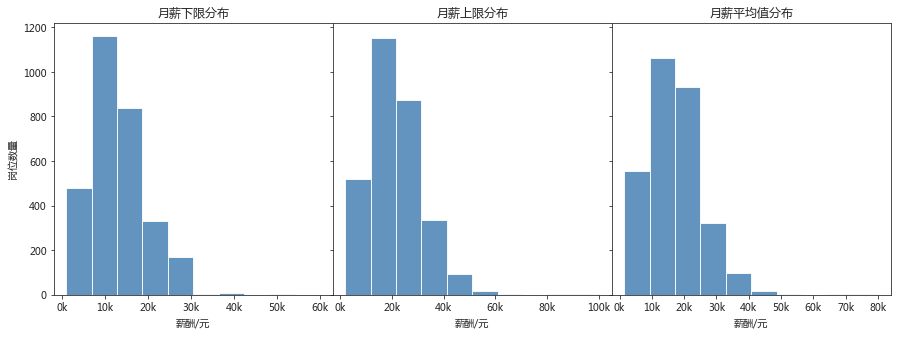

In [52]:
hist_salary3(jobs_lagou_clean)

从分布图来看，月薪下限会比较集中10k左右，月薪上限主要集中在20k左右，月薪平均值大多分布在10-22k区域，也就是说，数据分析岗位的月薪大多集中在这个区间.  <br>  
三个薪酬分布的图都近似正态分布，是正偏斜分布，尝试以对数进行转换。   
    
因月薪平均值较为中和上限与下限的情况，后续分析主要参考月薪平均值。

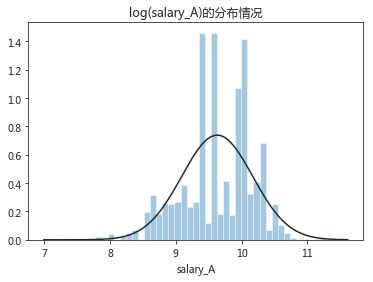

In [53]:
sns.distplot(np.log(jobs_lagou_clean['salary_A']),kde=False,fit=norm)
plt.title('log(salary_A)的分布情况');

<b>1. 地区</b>   
针对需求量前15名的城市进行分析

In [54]:
jobs_lagou_salary = jobs_lagou_clean[['companyFullName','positionName','positionLables',\
                                      'workYear','companySize','city','salary_A','ClsworkY','ClscompSize']]

In [55]:
#根据薪酬分布情况调整城市的次序
cities = ['北京','上海','深圳','杭州','广州','苏州','成都','厦门','南京','郑州','重庆','武汉','长沙','西安','合肥','其他']
cities = cities[::-1]
city_dict = defaultdict(int)
n = 0
for i in cities:
    city_dict[i] = n
    n += 1


In [56]:
jobs_lagou_salary['cityNo'] = jobs_lagou_salary['city'].map(city_dict)

In [57]:
def salary_box(col1,KWord,ticks,data):
    fig, ax = plt.subplots(1,1,figsize=(10,8))
    ax = sns.boxplot(x=col1,y='salary_A',data=data)
    ax.set(title='不同'+KWord+'薪酬情况',xlabel=KWord,ylabel='薪酬/元')
    ax.set_xticklabels(ticks)
    ax.yaxis.set_major_formatter(formatter)
    plt.show();

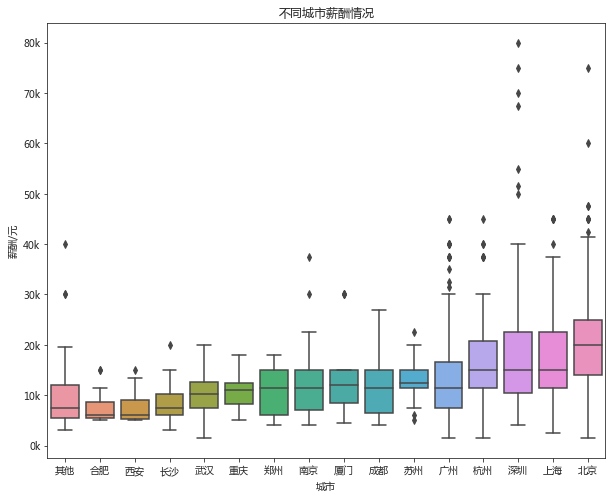

In [58]:
salary_box('cityNo','城市',cities,jobs_lagou_salary)

 不论是薪酬整体分布情况还是平均薪酬，均是北京为最高，中间段近50%的薪酬水平高于上海与深圳的平均薪酬，且高薪酬部分相对也比较多；      
 上海与深圳较为接近，上海的起薪会更低些，但Q1的薪酬水平会略高于深圳，而深圳的极高薪的情况是最多的；    
 杭州的平均薪酬与深圳持平，显著高于广州，这与杭州这个互联网产业比较发达密不可分；   
 在这四大主要城市之后的几大城市的平均薪酬较为接近，在10k附近。  

<b>2. 是否名企</b>   
因拉勾网主要面向的就是互联网招聘，在此以网上较公认的互联网大厂为名企名单进行筛选比较。  

In [59]:
# 列举的30家企业名称
fms_comp = ['阿里巴巴','腾讯','滴滴','知乎','搜狗','百度','奇虎','谷歌','华为','唯品会','搜狐','B站','乐视',\
            '微软','美图','网易','小米','字节跳动','京东','美团','去哪儿','饿了么','携程','苏宁','北京三快',\
            '途牛','五八','嘀嘀','奇艺','陌陌']

def check_fms(x):
    res = 0
    for i in fms_comp:
        ot = x.find(i)
        res += ot
    if res > -30:
        return 1
    else:
        return 0


In [60]:
jobs_lagou_salary['fms'] = jobs_lagou_salary['companyFullName'].apply(check_fms)

In [61]:
jobs_lagou_salary.head()

,companyFullName,positionName,positionLables,workYear,companySize,city,salary_A,ClsworkY,ClscompSize,cityNo,fms
0,人人行科技有限公司,数据分析,"['数据挖掘', 'SPSS']",3-5年,2000人以上,北京,11500,5,6,15,0
1,玖富金科控股集团有限责任公司,数据分析师,"['资深', '高级', '数据挖掘', 'SEM', '市场投放分析']",3-5年,2000人以上,北京,25000,5,6,15,0
2,广东省广告集团股份有限公司,数据分析师,"['旅游', '汽车', '广告营销', '大数据', '数据挖掘']",5-10年,2000人以上,广州,27500,6,6,11,0
3,广州牧云网络科技有限公司,数据分析师,"['资深', '大数据', '数据挖掘', 'SPSS', 'sas']",3-5年,150-500人,广州,12500,5,4,11,0
4,南京途牛科技有限公司,数据分析师,"['金融', 'SPSS', 'sas']",3-5年,2000人以上,南京,15000,5,6,7,1


In [62]:
jobs_salary_fms = jobs_lagou_salary.groupby('fms').count()['positionName']

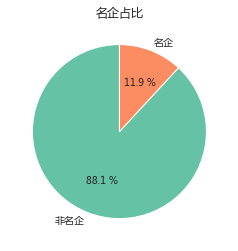

In [63]:
sns.set_palette('Set2')

plt.axes(aspect=1)
plt.pie(data=jobs_salary_fms, x=jobs_salary_fms.values, autopct='% 3.1f %%', labels=['非名企','名企'],\
        pctdistance=0.6,labeldistance=1.1, startangle=90, radius=1.0)
plt.title('名企占比')
plt.show();

名企的占比约12%，总体来说，占比不大，竞争也会比较激烈。   
  

In [64]:
company_num = len(jobs_lagou_salary['companyFullName'].unique())
job_total = len(jobs_lagou_salary['positionName'])
need_avg_fms = (0.12 * job_total)/30
need_avg_nonf = (0.88 * job_total)/ (company_num-30)
print('名企平均招聘需求:',need_avg_fms,'\n','非名企平均招聘需求:',need_avg_nonf)

名企平均招聘需求: 11.984 
 非名企平均招聘需求: 1.8398325191905094


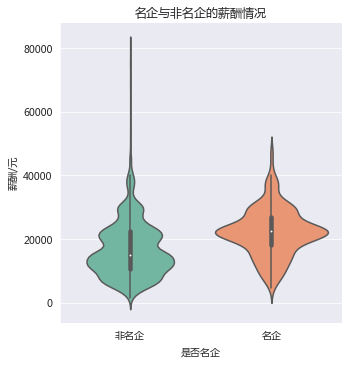

In [65]:
sns.set_style('darkgrid',{'font.sans-serif':'Microsoft YaHei'})
g = sns.catplot(x='fms',y='salary_A',kind="violin", data=jobs_lagou_salary)
#sns.swarmplot(x='fms',y='salary_A', color="k", size=2, data=jobs_lagou_salary, ax=g.ax);
g.set(title='名企与非名企的薪酬情况',xlabel='是否名企',ylabel='薪酬/元')
plt.xticks(range(2),['非名企','名企'])
plt.show();

名企的平均薪酬稍高于20k,且数量最多的情况就是在20k左右，往上有一个小幅的接近30k的分布集中区；   
非名企的薪酬总体上会比名企的偏低，平均薪酬在17k左右，分布情况呈现出更为明显的三个凸型，极高薪部分的情况更多。   


<b>3. 经验要求</b> 

In [66]:
jobs_salary_exp = jobs_lagou_salary.groupby('workYear').count()['positionName']

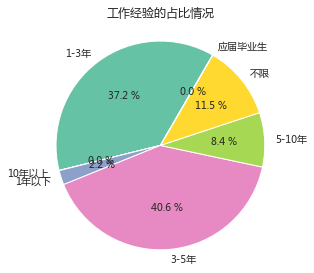

In [67]:
plt.axes(aspect=1)
plt.pie(data=jobs_salary_exp, x=jobs_salary_exp.values, autopct='% 3.1f %%', \
        labels=list(jobs_salary_exp.index),rotatelabels=0,\
        pctdistance=0.6,labeldistance=1.1, startangle=60, counterclock=True, radius=1.2)
plt.title('工作经验的占比情况', pad =20)
plt.show();

In [68]:
from pyecharts import Pie

attr = list(jobs_salary_exp.index)
v1 = list(jobs_salary_exp.values)
pie = Pie("工作经验的占比情况",title_pos='center')

pie.add("", attr, v1, radius=[0,45],legend_orient="vertical",legend_pos="right",is_label_show=True)
#pie.show_config()
pie

从对工作经验的要求来看，主要是3-5年和1-3年这两种情况，对于应届毕业生和1年工作经验以下的人群不是很友好，不过也有约12%的比例不是限工作经验。要求有5年工作经验以上还是比较少的。

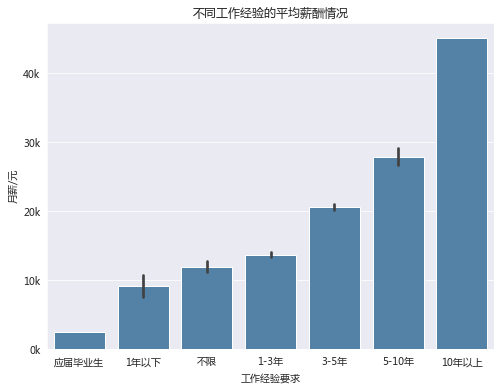

In [69]:
def draw_bar_salary(dataset, x_data):
    plt.figure(figsize=(8,6))
    ax = sns.barplot(x=x_data, y="salary_A", data=dataset, orient='v',\
                    order=['应届毕业生','1年以下','不限','1-3年','3-5年','5-10年','10年以上'],color='steelblue')
    ax.yaxis.set_major_formatter(formatter)
    plt.title('不同工作经验的平均薪酬情况')
    plt.ylabel('月薪/元')
    plt.xlabel('工作经验要求')
    plt.show();


draw_bar_salary(jobs_lagou_salary, 'workYear')

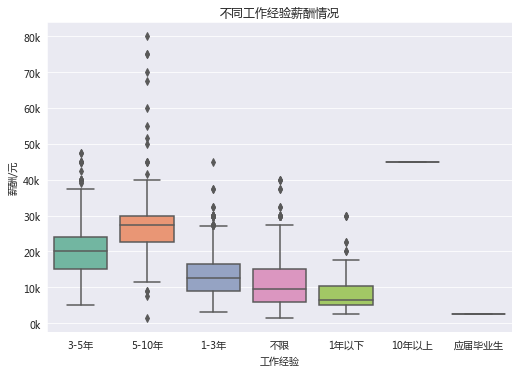

In [70]:
ax = sns.boxplot(x='workYear',y='salary_A',data=jobs_lagou_salary)
ax.set(title='不同工作经验薪酬情况',xlabel='工作经验',ylabel='薪酬/元')
ax.yaxis.set_major_formatter(formatter)
plt.subplots_adjust(top=1.2,right=1.2)
plt.show();

平均薪酬基本是随着工作经验的增长而上升的，工作经验不限的情况处于1年以下和1-3年的情况之间；       
工作经验10年以上的仅有一个岗位，属特例情况了，薪酬在40.5k左右；   
工作经验在5-10年的薪酬分布情况最好，中间段的最低薪酬都要高于3-5年的中间段薪酬的最高薪酬，且获得极高薪的机会最多；  
而主要占比的情况是1-3年和3-5年，平均薪酬相差近10k，不过要求1-3年经验的岗位也有极高薪的机会；  
对于工作经验不限的情况，薪酬分布的中间部分区间会更大，也有部分获得极高薪的机会；  
而应届毕业生和1年以下经验的岗位不仅占比少，且薪酬也是最低水平的。

<b>4. 公司规模</b> 

In [71]:
jobs_salary_size = jobs_lagou_salary.groupby('companySize').count()['positionName']

In [72]:
attr = list(jobs_salary_size.index)
v1 = list(jobs_salary_size.values)
pie = Pie("公司规模的占比情况",title_pos='center')

pie.add("", attr, v1, radius=[0,45],legend_orient="vertical",legend_pos="right",is_label_show=True)
#pie.show_config()
pie

对于数据分析岗位有需求的公司，大多都是规模较大的，从占比图中可知，80%的公司都在150人以上的规模，其中最多的是2000人以上，占比35%。

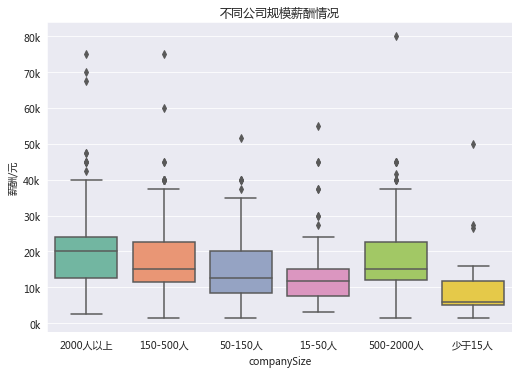

In [73]:
ax = sns.boxplot(x='companySize',y='salary_A',data=jobs_lagou_salary)
ax.set(title='不同公司规模薪酬情况',xlabel='companySize',ylabel='薪酬/元')
ax.yaxis.set_major_formatter(formatter)
plt.subplots_adjust(top=1.2,right=1.2)
plt.show();

因公司规模不同，平均薪酬的差异相对较小，但也呈小幅的上升趋势；   
平均薪酬能达到20k的也只有2000人规模以上的这样大公司，而少于15人的公司的平均薪酬却只在5k左右，头尾差距较大。   

<b>5. 岗位级别</b>

In [74]:
med_avg = get_data('中级')['salary_A'].mean()
pri_avg = get_data('专员')['salary_A'].mean()
print('提及中级的岗位平均月薪：',med_avg,'\n','提及专员的岗位的平均月薪：',pri_avg)

提及中级的岗位平均月薪： 18057.251908396946 
 提及专员的岗位的平均月薪： 12076.923076923076


In [75]:
#因提及中级的岗位平均月薪与总体平均月薪的平均值较为接近，故未提及岗位级别的岗位均按中级处理
def job_level(x):
    words = ''.join(x)
    if words.find('资深') != -1:
        return 5
    elif words.find('高级') != -1:
        return 4
    elif words.find('中级') != -1:
        return 3
    elif words.find('初级') != -1 or words.find('专员') != -1:
        return 2
    elif words.find('实习生') != -1 or words.find('助理') != -1:
        return 1
    else:
        return 3

In [76]:
#对岗位名称进行提取岗位级别信息
def job_level_pN(x):
    if x.find('实习生') != -1 or x.find('助理') != -1:
        return 1
    elif x.find('初级') != -1 or x.find('专员') != -1:
        return 2
    elif x.find('中级') != -1:
        return 3
    elif x.find('高级') != -1:
        return 4
    elif x.find('资深') != -1:
        return 5
    else:
        return 3

In [77]:
jobs_lagou_salary['pstLevel'] = jobs_lagou_salary['positionLables'].apply(job_level)

In [78]:
len(jobs_lagou_salary.loc[jobs_lagou_salary['pstLevel']==3].index)

2366

对岗位关键提取级别信息后，级别为3的岗位数有2366. 

In [79]:
for i in jobs_lagou_salary.loc[jobs_lagou_salary['pstLevel']==3].index:
    jobs_lagou_salary.loc[i,'pstLevel'] = job_level_pN(jobs_lagou_salary.loc[i,'positionName'])

In [80]:
len(jobs_lagou_salary.loc[jobs_lagou_salary['pstLevel']==3].index)

1772

对级别为3的岗位，再以岗位名称进行确认级别，最终得出级别为3的岗位数是1772.

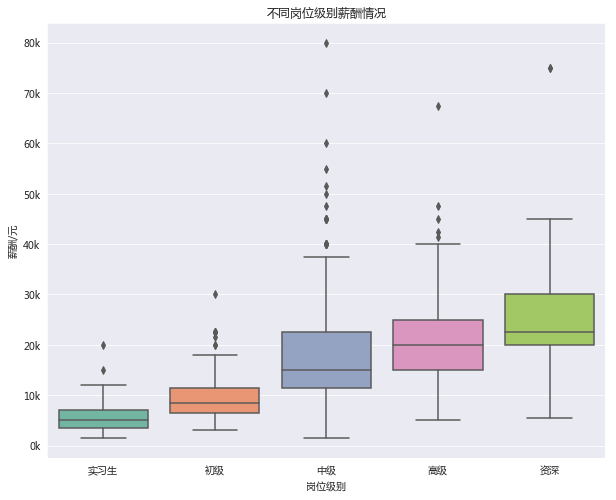

In [81]:
levels = ['实习生','初级','中级','高级','资深']
salary_box('pstLevel','岗位级别',levels,jobs_lagou_salary)

随着岗位级别的提高，不仅整体薪酬大幅提升，平均工资也是差异显著。    
资深级别的岗位平均薪酬超过20k/月，中间段下限已高于高级岗位的平均薪酬；   
中级岗位的薪酬分布会比较宽，较多岗位是处于平均薪酬以下的，但获得极高薪的机会最多，这可能与之前将未提及岗位级别的岗位全部归为中级有关。

In [82]:
jobs_lagou_salary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2996 entries, 0 to 3042
Data columns (total 12 columns):
companyFullName    2996 non-null object
positionName       2996 non-null object
positionLables     2996 non-null object
workYear           2996 non-null object
companySize        2996 non-null object
city               2996 non-null object
salary_A           2996 non-null int64
ClsworkY           2996 non-null int64
ClscompSize        2996 non-null int64
cityNo             2996 non-null int64
fms                2996 non-null int64
pstLevel           2996 non-null int64
dtypes: int64(6), object(6)
memory usage: 384.3+ KB


已将分析变量：工作经验、公司规模、城市、是否名企、岗位等级等全部转换成数值型定性变量。 

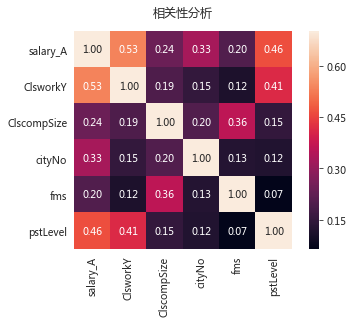

In [83]:
columns = jobs_lagou_salary.columns[6:]
sns.heatmap(jobs_lagou_salary.corr(),vmax=0.7, square=True,fmt='.2f',annot=True, annot_kws={'size': 10},\
            yticklabels=columns,xticklabels=columns)
plt.title('相关性分析',pad=15);

从相关性分析了解到，与平均薪酬相关系数最高的是工作经验，其次是岗位等级，第三是城市因素。   
这个结果与预期的较为相似，只是城市因素的相关性低于预期。 

另外，工作经验与岗位级别存在多重共线性的情况，相关系数为0.41,这与企业在招聘级别越高的岗位时，倾向于要求求职者经验丰富；   
是否名企与公司规模也存在一定的多重共线性关系，因提及的这些名企名单大多规模也是比较大的。   
<br>

#### 对薪酬待遇分析做一个小结    
<p>从地区、名企、经验要求、公司规模以及岗位等级等这五个方面进行了分析，初步得出如此结论：    
    1)不同地区的薪资待遇确实存在一定的差距，第一梯队主要是北京、上海、深圳、杭州、广州等一线城市，其次是南京、厦门、成都、武汉等较为热点的城市，与城市经济发展程度有一定相关性；    
    2)是否为互联网名企与薪资待遇的相关性不明显，这些名企虽不是薪资最高的前几大公司，但其薪酬分布情况在整体上会比非名单中的公司的薪酬分布情况要高，起薪也会稍高些；     
    3)不同工作经验要求的岗位待遇存在明显的差异，呈现出递增规律，即经验要求越高，薪次待遇也相应的更高；   
    4)公司规模大小对薪酬待遇也存在一定的影响，公司规模越大，整体上待遇水平会越高，但不是很显著的差异；  
    5)岗位级别与薪酬的相关性较高，岗位级别说明要求对求职者各方面的要求会更高，相应地，也会提供更高的薪酬。   

从上面的分析过程可知，要想提高薪酬，可从以下几个方面考虑：   
1）提升自己的能力，以适应更高等级的岗位   
2) 考虑去一线大城市，比如北京、深圳、杭州等，不仅整体薪酬水平会更高，也更有机会获得极高薪    
3）尽量选择规模较大的公司或者互联网大厂，不仅整体薪酬会更高，也有机会接触更全面的项目或向更多优秀的前辈学习    
4) 通过不断地自我努力与积累，有一定的工作经验之后，将更有机会获得高薪。   

#### 问题4. 公司侧重的福利主要有哪些？


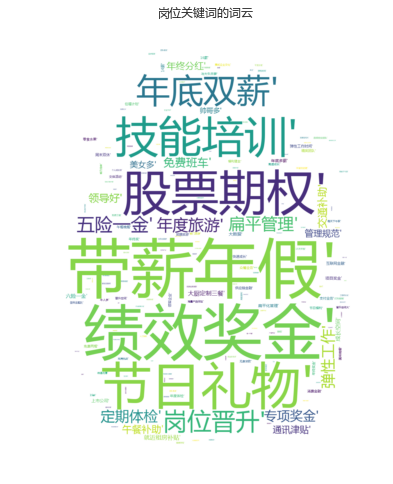

In [84]:
wel_text = get_words('companyLabelList')
draw_wordcloud(wel_text)

对于福利待遇方面，最高频的依次是‘带薪年假’，’绩效奖金‘，’节日礼物‘，’股票期权’，‘年底双薪’等。   
‘带薪年假’，’绩效奖金‘这两项是大多招聘中都会打出的福利项目了，经济务实。   
与其他招聘岗位相比，’股票期权’应该是比较有差异的一个福利了，这可能与很多需求数据分析岗位的公司有上市的情况有关。   

#### 问题5. 厦门对该岗位的需求情况及经验要求和薪资水平情况   
首先提取出厦门的招聘岗位信息，了解厦门地区对该岗位的需求情况，然后了解对于经验的要求和薪资待遇水平，以作为后续求职的参考。

In [85]:
jobs_lagou_clean_xiamen = jobs_lagou_clean[jobs_lagou_clean['city']=='厦门']
print("招聘数量: %s 个" % len(jobs_lagou_clean_xiamen))
#jobs_lagou_clean_xiamen

招聘数量: 19 个


In [86]:
print('厦门地区数据分析岗位的平均薪酬是:','% .1f'%(jobs_lagou_clean_xiamen['salary_A'].mean()/1000)+'k')

厦门地区数据分析岗位的平均薪酬是:  14.1k


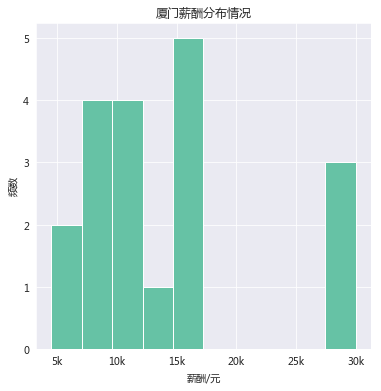

In [87]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
ax = jobs_lagou_clean_xiamen['salary_A'].hist()
ax.xaxis.set_major_formatter(formatter)
ax.set(title='厦门薪酬分布情况',xlabel='薪酬/元',ylabel='频数')

plt.show();

厦门数据分析招聘岗位数量总计19个，平均薪酬为14.1k；  
平均薪酬最高的达到了30k,有3个岗位； 平均薪酬在17k岗位数量最多，有5个； 有8个岗位是在10k左右。   

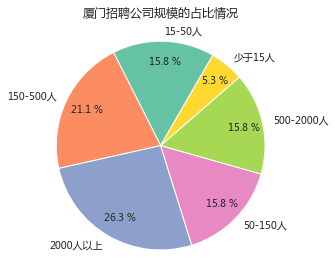

In [88]:
jobs_lagou_clean_xiamen_size = jobs_lagou_clean_xiamen.groupby('companySize',as_index=False).count()

plt.axes(aspect=1)
plt.pie(data=jobs_lagou_clean_xiamen_size, x=jobs_lagou_clean_xiamen_size['companyFullName'], \
        autopct='% 3.1f %%', labels=list(jobs_lagou_clean_xiamen_size['companySize']),rotatelabels=0,\
        pctdistance=0.8,labeldistance=1.1, startangle=60, counterclock=True, radius=1.2)
plt.title('厦门招聘公司规模的占比情况', pad =20)
plt.show();

厦门的公司中，多种规模的公司数量相当，大于60%的公司在150人的规模以上。  

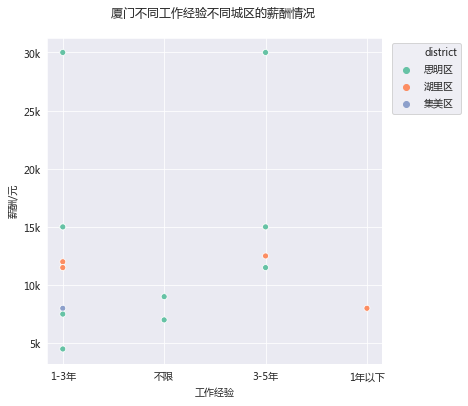

In [89]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
ax = sns.scatterplot(x='workYear',y='salary_A',hue='district',data=jobs_lagou_clean_xiamen)
ax.yaxis.set_major_formatter(formatter)
ax.set(title='厦门不同工作经验不同城区的薪酬情况 \n',ylabel='薪酬/元',xlabel='工作经验')
plt.legend(loc='upper right',ncol=1, bbox_to_anchor=(1.25, 1.0));

 厦门的数据分析岗位主要集中在思明区、湖里区，集美区数量较少，其中以思明区的薪酬情况更优，15k薪酬以上待遇的均在思明区。

<b>厦门数据分析岗位招聘情况小结</b>    
1. 招聘岗位的数量比较少，平均薪酬在14k，比厦门市平均薪酬不到8k的情况要高不少，还是比较有吸引力的；  
2. 随着工作经验的积累，薪酬会更为可观，且对于1-3年的工作经验就可以有拿30k薪酬的机会，让人充满遐想；   
3. 厦门公司的规模普遍还可以，大多在150人以上，岛内的工作比较比较多，薪酬也会更高些，特别是思明区，比较有机会获得更高的薪酬。

<br>
#### 问题6. 重点了解一下部分企业的需求与薪酬情况。   
1. 薪酬比较高的公司有哪些？薪酬水平如何？ 
2. 分招聘公司来看一下需求较多的公司有哪些？薪酬水平如何？ 

In [18]:
jobs_lagou_clean_company = jobs_lagou_clean.groupby(["companyFullName"]).mean()
jobs_lagou_clean_company.sort_values(by='salary_A',ascending=False)[:15]   #sort by one column

,salary_L,salary_U,salary_A,ClsworkY,ClscompSize
companyFullName,,,,,
深圳市创梦天地科技有限公司,60000.000000,100000.000000,80000.000000,6.0,5.0
深圳市康恩诺科技有限公司,47500.000000,95000.000000,71250.000000,6.0,6.0
东莞市西弗企业管理咨询有限公司,40000.000000,70000.000000,55000.000000,6.0,2.0
深圳巴古思科技有限公司,40000.000000,60000.000000,50000.000000,6.0,1.0
深圳乐贤企业管理咨询顾问有限公司,30000.000000,60000.000000,45000.000000,5.0,2.0
深圳市麦达数字股份有限公司,30000.000000,60000.000000,45000.000000,5.0,5.0
上海睿利郡网络科技有限公司,30000.000000,60000.000000,45000.000000,5.0,2.0
中信云网有限公司,30000.000000,60000.000000,45000.000000,5.0,5.0
税友软件集团股份有限公司,30000.000000,60000.000000,45000.000000,7.0,6.0


从薪资待遇前15名的情况来看
1. 薪酬均在40k及以上，甚至有2家公司的薪酬在70k以上；   
2. 大多公司是来自深圳和北京的，且以深圳的高薪情况多且更高；     
3. 对工作经验的要求几乎都在级别5以上，即3-5年工作经验及以上，前4名的岗位均要求5年工作经验以上；   
4. 这些公司中少有来自互联网大厂名单中的企业。   

In [19]:
# 取招聘需求达10位的公司
company_demand = jobs_lagou_clean['companyFullName'].value_counts()
main_companies = company_demand[company_demand.values >= 10].index
print('招聘需求达10位的公司数量：',len(main_companies),'\n','公司名单：','\n',main_companies)

招聘需求达10位的公司数量： 37 
 公司名单： 
 Index(['北京字节跳动科技有限公司', '北京三快在线科技有限公司', '腾讯科技(深圳)有限公司', '北京京东世纪贸易有限公司',
       '浙江执御信息技术有限公司', '拉扎斯网络科技（上海）有限公司', '北京五八到家信息技术有限公司',
       '车好多旧机动车经纪(北京)有限公司', '凡普金科集团有限公司', '北京斗米优聘科技发展有限公司', '北京数美时代科技有限公司',
       '北京嘀嘀无限科技发展有限公司', '北京世纪好未来教育科技有限公司', '上海基分文化传播有限公司', '京东金融',
       '北京瓴岳信息技术有限公司', '北京奇艺世纪科技有限公司', '链家网（北京）科技有限公司', '北京国双科技有限公司',
       '百融金融信息服务股份有限公司', '南京网燃网络科技有限公司', '银客未来科技（北京）有限公司', '上海海万信息科技股份有限公司',
       '维沃移动通信有限公司', '便利蜂商贸有限公司', '北京陌陌科技有限公司', '中腾信金融信息服务（上海）有限公司',
       '百度在线网络技术（北京）有限公司', '北京尚德在线教育科技有限公司', '美味不用等（上海）信息科技股份有限公司',
       '网易（杭州）有限公司', '优舫（北京）信息科技有限公司', '唯品会（中国）有限公司', '深圳市和讯华谷信息技术有限公司',
       '北京车之家信息技术有限公司', '厦门美图之家科技有限公司', '北京小米科技有限责任公司'],
      dtype='object')


In [20]:
jobs_lagou_clean_main_companies = jobs_lagou_clean[jobs_lagou_clean['companyFullName'].isin(main_companies)]
print('这37家公司的招聘需求量:',len(jobs_lagou_clean_main_companies))
#jobs_lagou_clean_main_companies.head()

这37家公司的招聘需求量: 612


In [21]:
jobs_lagou_clean_main_companies.describe()

,salary_L,salary_U,salary_A,ClsworkY,ClscompSize
count,612.000000,612.000000,612.000000,612.000000,612.000000
mean,15514.705882,27710.784314,21612.745098,4.604575,5.622549
std,6133.120576,10860.656545,8353.554139,0.831369,0.850348
min,2000.000000,3000.000000,2500.000000,2.000000,1.000000
25%,10000.000000,20000.000000,15000.000000,4.000000,5.000000
50%,15000.000000,30000.000000,22500.000000,5.000000,6.000000
75%,20000.000000,35000.000000,27000.000000,5.000000,6.000000
max,50000.000000,90000.000000,70000.000000,6.000000,6.000000


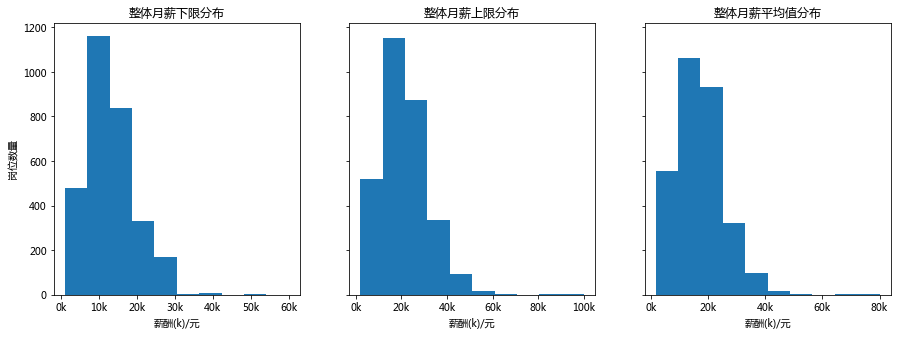

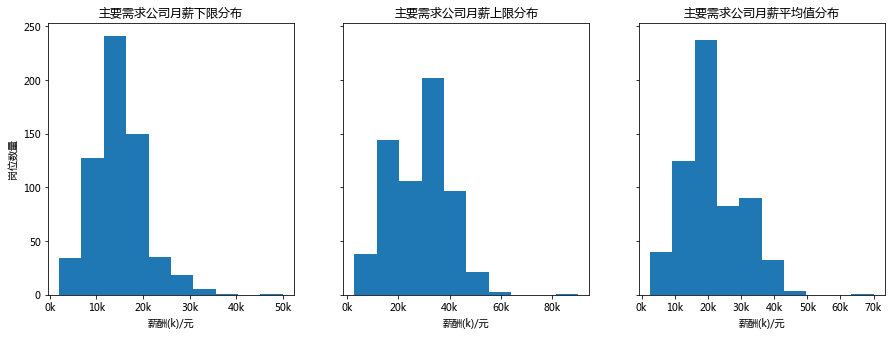

In [26]:
fig1, ax1 = plt.subplots(1,3,sharey=True,figsize=(15,5))
axes1 = ax1.ravel()

axes1[0].hist(jobs_lagou_clean['salary_L'])
props1={'title':'整体月薪下限分布','ylabel':'岗位数量','xlabel':'薪酬(k)/元'}
axes1[0].set(**props1)
axes1[0].xaxis.set_major_formatter(formatter)

axes1[1].hist(jobs_lagou_clean['salary_U'])
props2={'title':'整体月薪上限分布','xlabel':'薪酬(k)/元'}
axes1[1].set(**props2)
axes1[1].xaxis.set_major_formatter(formatter)

axes1[2].hist(jobs_lagou_clean['salary_A'])
props3={'title':'整体月薪平均值分布','xlabel':'薪酬(k)/元'}
axes1[2].set(**props3)
axes1[2].xaxis.set_major_formatter(formatter)

fig2, ax2 = plt.subplots(1,3,sharey=True,figsize=(15,5))
axes2 = ax2.ravel()

axes2[0].hist(jobs_lagou_clean_main_companies['salary_L'])
props4={'title':'主要需求公司月薪下限分布','ylabel':'岗位数量','xlabel':'薪酬(k)/元'}
axes2[0].set(**props4)
axes2[0].xaxis.set_major_formatter(formatter)

axes2[1].hist(jobs_lagou_clean_main_companies['salary_U'])
props5={'title':'主要需求公司月薪上限分布','xlabel':'薪酬(k)/元'}
axes2[1].set(**props5)
axes2[1].xaxis.set_major_formatter(formatter)

axes2[2].hist(jobs_lagou_clean_main_companies['salary_A'])
props6={'title':'主要需求公司月薪平均值分布','xlabel':'薪酬(k)/元'}
axes2[2].set(**props6)
axes2[2].xaxis.set_major_formatter(formatter)

plt.show()

从主要需求公司的名单来看，包括了大多数的大厂、名企，以此名单作为名企来分析。    
从统计数据来看，主要需求公司的情况如下（括号中为整体值）：   
月薪下限的平均薪酬是15.4(12.6k），中位数是15k（10k），最高为50k（60k）；  
月薪上限的平均薪酬是27.6(22.1k），中位数是30k（20k），最高为90k（100k）；   
月薪平均值的平均薪酬是21.5k（17.4k），中位数是22.5k（15k），最高为70k（80k）。   
除最高值会稍小于整体情况的，即说明最高薪不在这些主要需求公司中，月薪上、下限的平均薪酬、中位数均是高于整体水平的。    

从分布图来看，薪资平均值都是主要集中在20k左右，但主要需求公司的占比会更高，而薪资下限与薪资上限方面，主要需求公司的高薪部分占比会更多些，即会比整体水平偏高。    

综上，公司是否名企可能不会提供最具竞争力的薪酬，但可推测出薪酬水平会比整体水平要更高，不过这其中也应该有地区差异的因素，毕竟这些大企业基本上都在较为发达的城市。


下面针对一些较为感兴趣的公司进行单独分析，了解需求情况、岗位方向及薪资待遇水平等。

In [95]:
jobs_lagou_clean.loc[jobs_lagou_clean['salary_A'].idxmax()]

companyFullName                        深圳市创梦天地科技有限公司
positionName                                  数据分析专家
positionLables         ['游戏', '广告营销', '大数据', '数据挖掘']
salary                                      60k-100k
workYear                                       5-10年
createTime                       2018-05-29 14:43:16
companySize                                500-2000人
companyLabelList    ['绩效奖金', '五险一金', '带薪年假', '节日礼物']
city                                              深圳
district                                         南山区
salary_L                                       60000
salary_U                                      100000
salary_A                                       80000
ClsworkY                                           6
ClscompSize                                        5
Name: 1269, dtype: object

薪资水平最高的一家公司是深圳市创梦天地科技有限公司，薪资范围是60k-100k，坐标深圳，仅招聘一名，从岗位标签推测应为游戏公司的广告业务方面。

In [96]:
def company_analysis(name):
    jobs_company = jobs_lagou_clean[jobs_lagou_clean['companyFullName']==name]
    positionList = {}
    cities = jobs_company['city'].unique()
    for i in cities:
        positionList[i] = len(jobs_company[jobs_company['city']== i])
    print("各地区需求情况： ", positionList)
    print("招聘岗位的名称： ", jobs_company['positionName'].unique())
    if len(jobs_company) > 2 and len(cities) > 2:
        print(jobs_company.describe())
        ax = sns.scatterplot(x='city',y='salary_A',data=jobs_company)
        ax.yaxis.set_major_formatter(formatter)
        ax.set(title=name + '的薪酬情况',xlabel='城市',ylabel='薪资待遇/元')
        plt.subplots_adjust(top=1.2,right=1.2);
    elif len(jobs_company) > 2:
        ax = sns.scatterplot(x='positionName',y='salary_A',hue='city',data=jobs_company)
        ax.yaxis.set_major_formatter(formatter)
        ax.set(title=name + '的薪酬情况',xlabel='岗位名称',ylabel='薪资待遇/元')
        plt.xticks(rotation=90)
        plt.subplots_adjust(top=1.2,right=1.2);
    else:
        print(jobs_company)
    

各地区需求情况：  {'武汉': 1, '北京': 42, '天津': 1, '深圳': 4, '南京': 1, '上海': 2}
招聘岗位的名称：  ['数据分析师' '数据分析专员' '商业资源运营经理-数据分析方向' '数据分析师-直播方向' '数据分析师-电商方向' '资深数据分析师'
 '数据分析师-国际化产品' '商业产品运营经理-数据分析' '数据分析师-内容付费' '商业化数据分析师' '行业数据分析师' '数据分析员主管'
 '高级数据分析师' '数据分析师（高级/资深）' '数据分析师-faceu' '高级数据分析/挖掘-faceu' '数据分析师-内容生态方向'
 '数据分析师-国际化运营' '数据分析师-统计模型方向' '资深数据分析专家' '高级行业数据分析师' '商业化资深数据分析师'
 '商业化数据分析经理' '数据仓库与数据分析高级工程师' '商业数据分析师-新业务' '风险数据分析师' '商业化电商数据分析师'
 '数据分析师（国际化产品）' '数据分析师（站内活动方向）' '高级游戏联运数据分析师' '舆情数据分析师' '渠道高级数据分析专员'
 'HR数据分析师' '数据分析师（国际化运营）' '运营平台高级数据分析师' '用户数据分析师']
           salary_L      salary_U      salary_A   ClsworkY  ClscompSize
count     51.000000     51.000000     51.000000  51.000000         51.0
mean   15372.549020  29235.294118  22303.921569   4.470588          6.0
std     5810.200631  10110.565237   7893.084588   0.643520          0.0
min     4000.000000   6000.000000   5000.000000   3.000000          6.0
25%    14000.000000  25000.000000  19500.000000   4.000000          6.0
50%    15000.000000

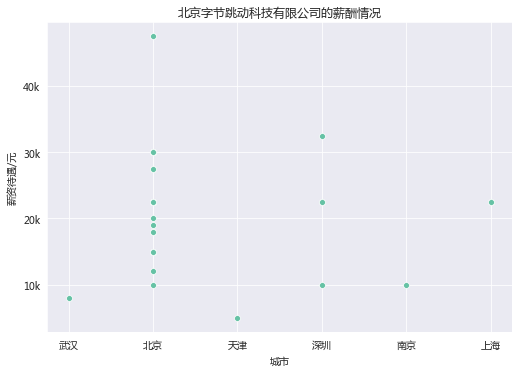

In [97]:
company_analysis('北京字节跳动科技有限公司')

各地区需求情况：  {'北京': 45, '厦门': 1, '上海': 1}
招聘岗位的名称：  ['数据分析专家' '高级数据分析师' '商业分析-数据分析' '数据分析师' '数据分析经理' 'BI-数据分析/数据产品' '数据分析专员'
 '数据分析' '呼叫中心-数据分析师' '数据分析-创新方向' '钱包业务-高级数据分析师' '商业分析/策略运营/数据分析'
 '数据分析（kpi方向）' '高阶数据分析师' '闪付业务-高级数据分析师' '数据分析（违规方向）' '数据分析师-景区'
 '数据分析岗-业务发展部' '高级数据分析师-用户研究' '商业分析（数据分析）' '数据分析-外卖渠道' '业务主管（数据分析）'
 '商业数据分析师' '数据分析高级主管' '高星酒店业务数据分析师' '高级数据分析' '高级商业分析师（数据分析方向）'
 '收银产品组-数据分析产品经理' '数据分析专员（配送审核组）' '集团研究院-BI数据分析师' '数据分析（配送运营方向）'
 'BI数据分析师&nbsp;&nbsp;（跑腿业务策略）' '高级运营专员（配送开放平台数据分析方向）' '业务运营（数据分析）'
 '位置大数据分析技术专家']
           salary_L      salary_U      salary_A   ClsworkY  ClscompSize
count     47.000000     47.000000     47.000000  47.000000         47.0
mean   16808.510638  29212.765957  23010.638298   4.829787          6.0
std     5375.622503   9791.158767   7379.826616   0.816119          0.0
min     8000.000000  13000.000000  10500.000000   2.000000          6.0
25%    15000.000000  20000.000000  17500.000000   5.000000          6.0
50%    15000.000000  30000.000000  225

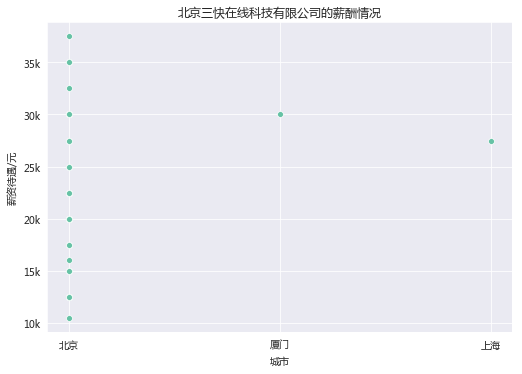

In [98]:
company_analysis('北京三快在线科技有限公司')

各地区需求情况：  {'成都': 1, '北京': 10, '深圳': 31, '广州': 3}
招聘岗位的名称：  ['数据分析' '23048-数据分析师' 'mig -- 数据分析师' 'WXG01-111 微信数据分析师（广州）' '高级数据分析师（北京）'
 '高级数据分析师' '数据分析开发工程师' 'MIG13-大数据分析师（深圳）' '数据分析工程师（深圳）'
 '20718-数据分析工程师（深圳）' '数据分析工程师（北京）' 'SNG16-数据分析工程师（深圳）' 'SNG_BI_高级数据分析师'
 'HY2-高级数据分析开发工程师（深圳）' '腾讯（深圳）大数据-数据挖掘、数据分析工程师' '25924-HY-数据分析开发工程师（深圳）'
 '风控（海外）策略及数据分析工程师（深圳）' '18402-暗黑类手游数据分析和挖掘' '微信搜索数据分析工程师'
 'SA-腾讯社交广告数据分析师 （深圳 ）' '微信搜索推荐数据分析工程师（深圳）' 'SA-腾讯社交广告数据分析工程师（微信广告 深圳）'
 'SA-腾讯社交广告数据分析工程师（微信广告方向）' '大数据分析挖掘工程师-数字广东公司（腾讯投资）' 'MIG03-高级数据分析师（深圳）'
 '高级数据分析师（深圳）' '数据分析开发工程师（深圳）' '数据分析开发工程师（北京）' '视频数据分析'
 'MIG03-腾讯LBS大数据分析师（北京）' '18402-【侍魂】手游数据分析' 'MIG08-数据分析产品经理'
 '18402-次世代高自由度MMORPG手游数据分析' '投资孵化中心大数据分析师（深圳）' '移动游戏高级数据分析师'
 '21228-女性向游戏数据分析（深圳）' '19116-腾讯觅影数据分析高级产品经理（深圳）' '体育电商业务经营数据分析'
 '腾讯-王者荣耀电竞市场数据分析（深圳）' '广告销售数据分析师（北京）' '23517-《仙侠类MMO》手游数据分析师'
 'MIG07-安全大数据分析（深圳）' '25926-用户画像大数据分析工程师（深圳）']
           salary_L      salary_U      salary_A   ClsworkY  ClscompSize
count     45.000000     45.000000 

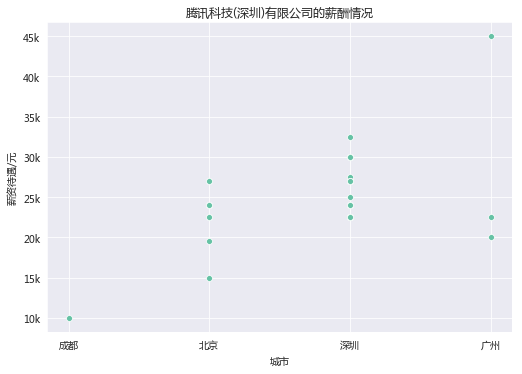

In [99]:
company_analysis('腾讯科技(深圳)有限公司')

各地区需求情况：  {'北京': 29, '深圳': 1, '成都': 2, '上海': 1}
招聘岗位的名称：  ['数据分析师' '数据分析岗' '数据分析师岗' '数据分析' '数据分析专家' '数据分析师（AI方向）' '数据分析师（全球购）'
 '高级数据分析师' '广告数据分析师' '数据分析高级经理' '市场数据分析岗' '商业数据分析部署工程师' '数据分析师岗（数据挖掘方向）'
 '风控数据分析师' '采销数据分析岗' '采销数据分析' '商业数据分析']
           salary_L      salary_U      salary_A   ClsworkY  ClscompSize
count     33.000000     33.000000     33.000000  33.000000         33.0
mean   13515.151515  24242.424242  18878.787879   5.000000          6.0
std     4691.223269   9233.195218   6890.925082   0.790569          0.0
min     7000.000000  10000.000000   8500.000000   3.000000          6.0
25%    10000.000000  18000.000000  15000.000000   5.000000          6.0
50%    15000.000000  24000.000000  19000.000000   5.000000          6.0
75%    15000.000000  30000.000000  22500.000000   5.000000          6.0
max    25000.000000  50000.000000  37500.000000   6.000000          6.0


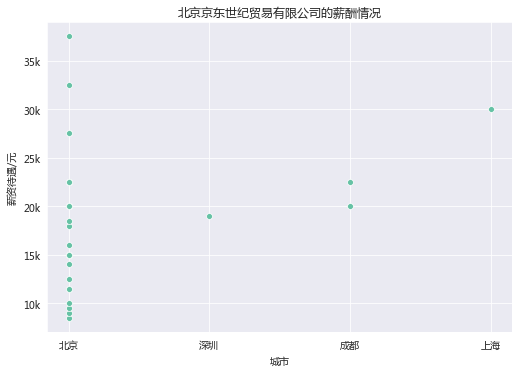

In [100]:
company_analysis('北京京东世纪贸易有限公司')

各地区需求情况：  {'北京': 15, '长沙': 3}
招聘岗位的名称：  ['数据分析师（中台）' '数据分析、算法' '数据挖掘、数据分析' '策略运营/数据分析' '数据分析师' '市场调研/策略运营/数据分析'
 '数据运营/运营专员/数据分析/数据支持' '资深数据分析' '数据分析师-投资并购' '数据分析师（开放平台）']


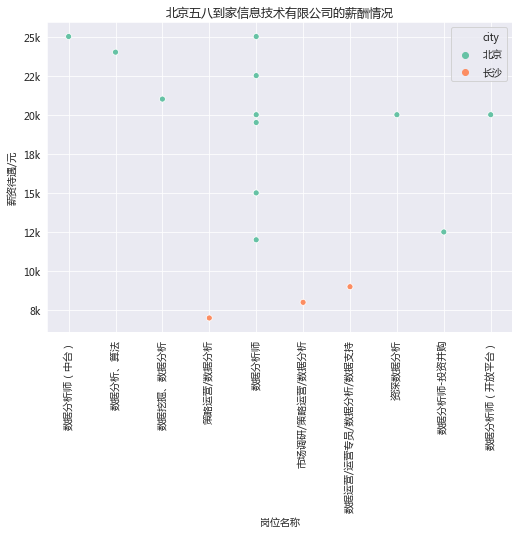

In [101]:
company_analysis('北京五八到家信息技术有限公司')

各地区需求情况：  {'北京': 13, '上海': 2}
招聘岗位的名称：  ['数据分析专家' '数据分析师--大数据策略(J14734)' '数据分析师(J171124002)'
 '数据分析师专家/数据工程师专家(J180326018)' '数据分析专家/数据工程专家(J180326017)' '数据分析师'
 '高级数据分析师(J180126022)' '数据分析经理' '数据分析专员(J180206034)'
 '数据科学家/数据分析高级专家(J180424005)' '数据分析师（BI）(J171025015)'
 '运营数据分析专家-北京(J171226006)']


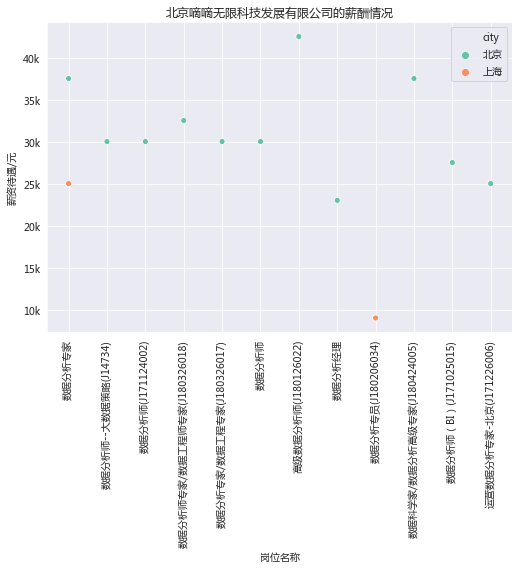

In [102]:
company_analysis('北京嘀嘀无限科技发展有限公司')

各地区需求情况：  {'杭州': 2, '北京': 1}
招聘岗位的名称：  ['蚂蚁金服-数据分析专家/高级专家' '高德-NLP/推荐算法/数据挖掘/数据分析/图谱' '风险数据分析师']


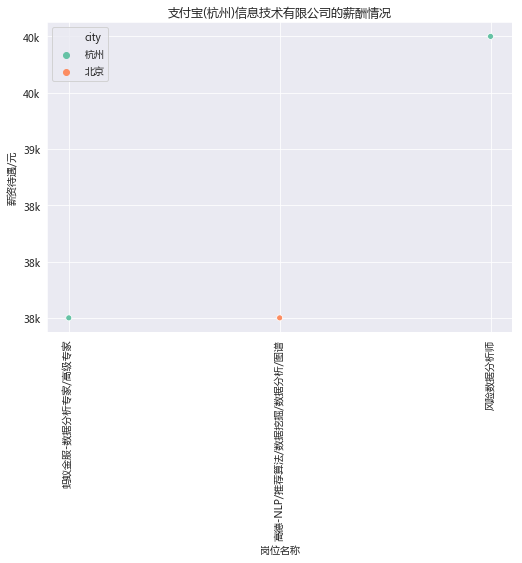

In [103]:
company_analysis('支付宝(杭州)信息技术有限公司')

In [104]:
company_analysis('口碑（杭州）信息技术有限公司')

各地区需求情况：  {'杭州': 1}
招聘岗位的名称：  ['口碑-商业数据分析专家-数据中心招募']
     companyFullName        positionName           positionLables   salary  \
2366  口碑（杭州）信息技术有限公司  口碑-商业数据分析专家-数据中心招募  ['大数据', '数据挖掘', 'SPSS']  25k-50k   

     workYear          createTime companySize companyLabelList city district  \
2366     3-5年 2018-05-14 20:55:11     2000人以上               []   杭州      西湖区   

      salary_L  salary_U  salary_A  ClsworkY  ClscompSize  
2366     25000     50000     37500         5            6  


<br>
<br>
### 总结
1. 大多数数据分析岗位的薪酬集中在10-30k，只有少数人可以获得更高的薪酬，极少数人获得极高的薪酬；   
2. 不同城市数据分析岗位的需求量与薪酬存在差异，以北京的需求量最大，占去近一半的机会，薪酬方面北京最高，深圳、上海和杭州仅次于北京，在深圳获得极高薪酬的机会最多；  
3. 数据分析岗位对工作经验的要求主要集中在3-5年和1-3年，随工作经验的提升，薪酬也呈增长趋势，在5-10年或10年以上工作经验的人，有机会获得比较丰厚的待遇；   
4. 数据分析岗位有点偏向技术岗位的性质，针对岗位的职责与水平要求，有设定不同的级别，级别越高，薪酬待遇越好，努力成为一个能力更强的人去胜任更高级别的岗位以争取更高的薪酬；   
5. 在大公司和名企中，虽然不一定可都能获得极高部分的薪酬，但整体薪酬也高于一般企业；在单个公司分析的情况中，大多在北京者阴招聘需求，而且薪酬相比北京之外的地区，都要高出不少；     
6. 招聘公司有不同的行业，同样的数据分析岗位也有设有不同的职责方向，对技能的需求水平存在不同的要求，可根据实际情况找准方向提升自己，让自己获得更高的竞争力。   